# Benchmark Notebook
This notebook shows a quick python interface usage of the package `sr-metric`.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.fftpack import fft2, fftshift, ifft2

# Add the relative path to ../SRmetric
sys.path.append(os.path.abspath(os.path.join('..')))

from SRmetric.metric import *
from SRmetric.utils import *

## Load Image

In [2]:
WF_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3_20241031_130414_WF.tif"
SR_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3.mrc"

# WF_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3_20241031_145214_WF.tif"
# SR_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3.mrc"

In [3]:
wf_img = im_read(WF_PATH)
sr_img = im_read(SR_PATH)

print(wf_img.shape)
print(sr_img.shape)

voxel size: (0.03065, 0.03065, 0.05)
(1024, 1024)
(3, 1024, 1024)


/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:238: RuntimeWarning: Machine stamp '0x00 0x00 0x00 0x00' does not match the apparent byte order '>'
  warnings.warn(msg.format(pretty_machst, header.mode.dtype.byteorder),


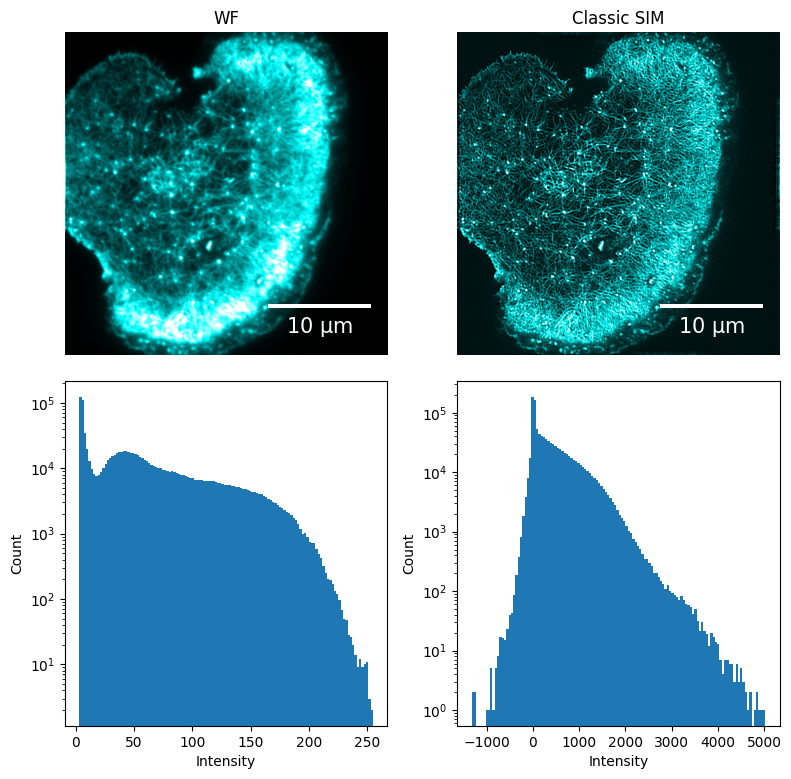

In [4]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0,0].set_axis_off()
axs[0,0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,0].add_artist(scalebar)
axs[1,0].hist(wf_img.ravel(),bins=128)
axs[1,0].set_yscale("log")
axs[1,0].set_ylabel("Count")
axs[1,0].set_xlabel("Intensity")

axs[0,1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[0,1].set_axis_off()
axs[0,1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,1].add_artist(scalebar)
axs[1,1].hist(sr_img[0].ravel(),bins=128)
axs[1,1].set_yscale("log")
axs[1,1].set_ylabel("Count")
axs[1,1].set_xlabel("Intensity")

fig.tight_layout()

## Performance Benchmark

Compute global image relative metrics of 
- Normalized Mean Squared Error (nMSE)   
- Peak Signal Noise Ratio (PSNR)    
- Structural Similarity Index (SSIM)
- Pearson's Cross Correlation (PCC)
- Mutual Information (MI)

and relative FRC and self FRC as the equation:

$$
\text{FRC}(r)=\frac{\sum_{k\in r}F_1(k)\cdot F_2^*(k)}{\sqrt{\sum_{k\in r}\left|F_1(k)\right|^2\cdot\sum_{k\in r}\left|F_2(k)\right|^2}}
$$

Here:
- $F_i$ is Fourier transform of the given image.
- $r$ is a ring in Fourier space (defined by the frequency radius).
- $F_1$ and $F_2$ are the Fourier transforms of the two sub-images.
- $F_2^*$ is the complex conjugate of $F_2$

Image Relative Metric:
nMSE    26.368402
PSNR    12.279863
SSIM     0.163100
PCC      0.851497
MI       0.871478
dtype: float64
1/7 Frequency Value (Normalized): 0.3300
Real Resolution: 0.19 um
1/7 Frequency Value (Normalized) [img1]: 0.9000
Real Resolution [img1]: 0.14 um
1/7 Frequency Value (Normalized) [img2]: 0.9500
Real Resolution [img2]: 0.06 um


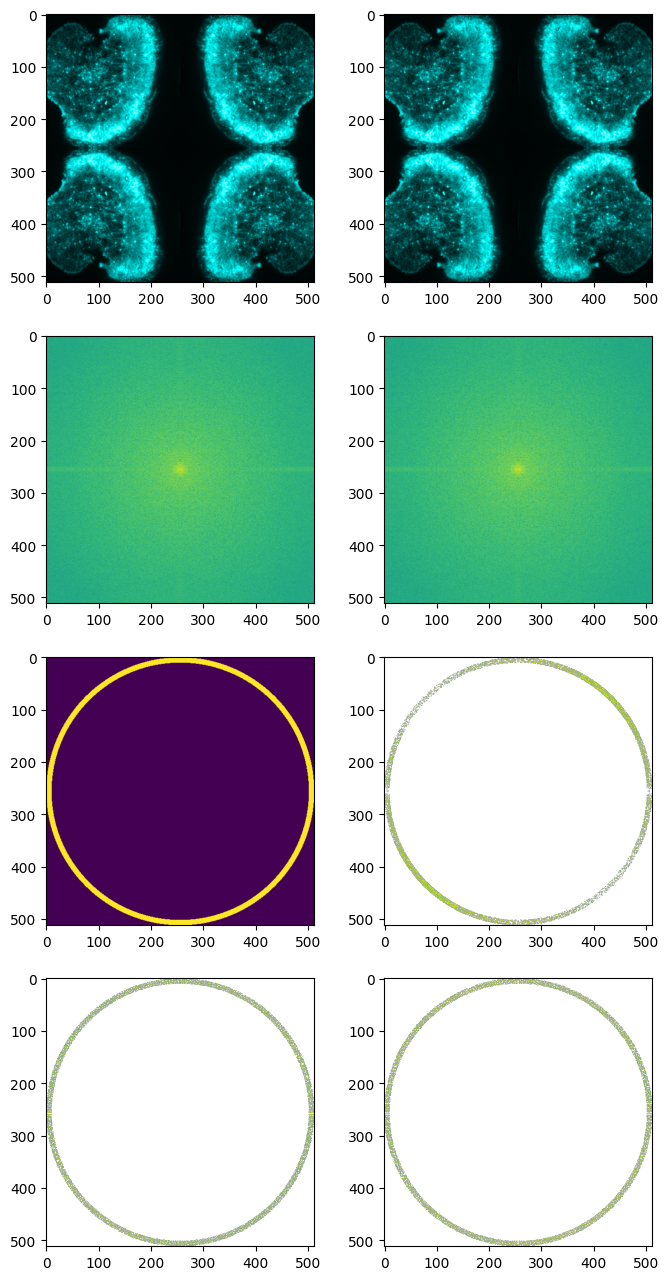

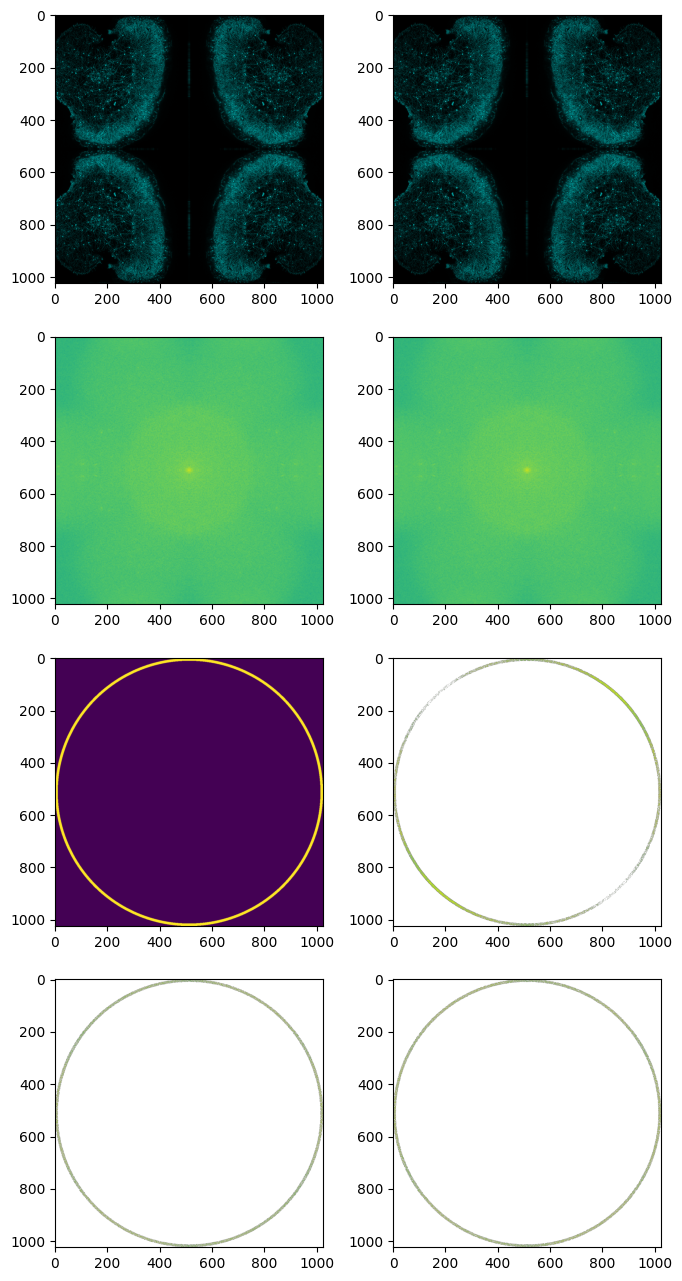

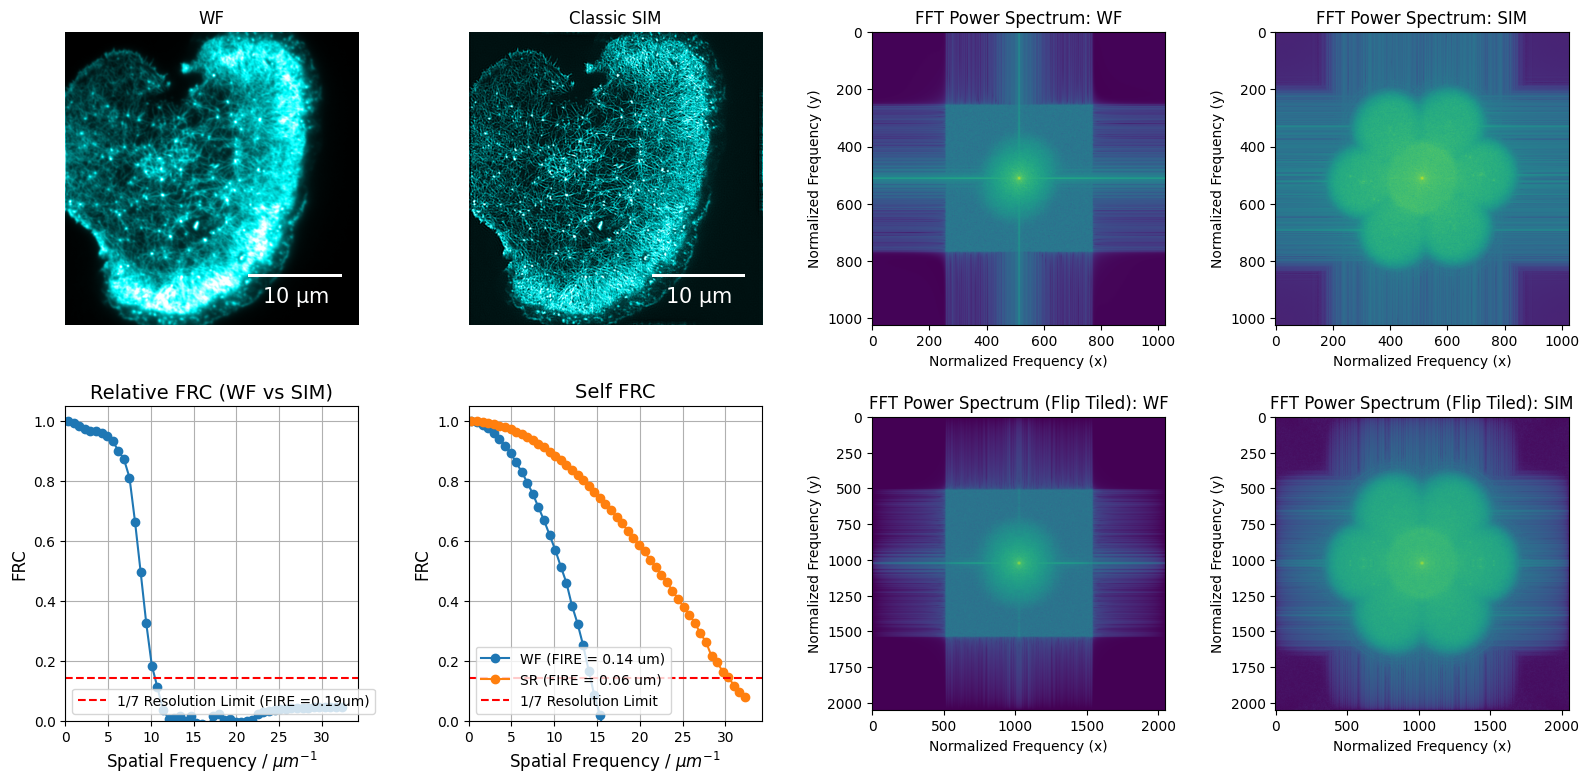

In [5]:
PX_SIZE = 0.03065
SAMPLING_RATE= [2,1]

# srmetric = SRMetric(wf_img,sr_img[0],pixel_size=PX_SIZE)
srmetric = SRMetric(wf_img,sr_img[0],pixel_size=PX_SIZE)
metric = srmetric.compute_metric()

# Compute FRC
freq, frc_val, res, frc_cross_freq = srmetric.compute_frc(flip_tile=False)
print(f"1/7 Frequency Value (Normalized): {frc_cross_freq:.4f}")
print(f"Real Resolution: {res:.2f} um")

# Compute self FRC
freq_self, frc_val_self, res_self, frc_cross_freq_self = srmetric.compute_self_frc(sampling_rate=SAMPLING_RATE,sampling_method="Fourier",flip_tile=True, plot=True) # the WF image may need to subsample by half
if frc_cross_freq_self[0]:
    print(f"1/7 Frequency Value (Normalized) [img1]: {frc_cross_freq_self[0]:.4f}")
    print(f"Real Resolution [img1]: {res_self[0]:.2f} um")
else:
    print("1/7 Frequency Value (Normalized) [img1]: Undetermined")
    print("Real Resolution [img1]: Undetermined")
if frc_cross_freq_self[1]:
    print(f"1/7 Frequency Value (Normalized) [img2]: {frc_cross_freq_self[1]:.4f}")
    print(f"Real Resolution [img2]: {res_self[1]:.2f} um")
else:
    print("1/7 Frequency Value (Normalized) [img2]: Undetermined")
    print("Real Resolution [img2]: Undetermined")

fig, axs = plt.subplots(2,4,figsize=(16,8))

axs[0,0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0,0].set_axis_off()
axs[0,0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(PX_SIZE, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,0].add_artist(scalebar)

axs[0,1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[0,1].set_axis_off()
axs[0,1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(PX_SIZE, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,1].add_artist(scalebar)

# plot the power spectrum of the input images
fft_1 = fftshift(fft2(wf_img))
fft_2 = fftshift(fft2(sr_img[0]))
mag1 = np.abs(fft_1)
mag2 = np.abs(fft_2)
power_spectrum1 = np.log(1 + mag1**2)
power_spectrum2 = np.log(1 + mag2**2)    
axs[0,2].imshow(power_spectrum1, cmap='viridis')
# axs[0,2].imshow(power_spectrum1, cmap='viridis', extent=(-1, 1, -1, 1))
axs[0,2].set_title('FFT Power Spectrum: WF')
axs[0,2].set_xlabel('Normalized Frequency (x)')
axs[0,2].set_ylabel('Normalized Frequency (y)')
axs[0,3].imshow(power_spectrum2, cmap='viridis')
# axs[0,3].imshow(power_spectrum2, cmap='viridis', extent=(-1, 1, -1, 1))
axs[0,3].set_title('FFT Power Spectrum: SIM')
axs[0,3].set_xlabel('Normalized Frequency (x)')
axs[0,3].set_ylabel('Normalized Frequency (y)')


fft_1 = fftshift(fft2(image_flip_tile(wf_img)))
fft_2 = fftshift(fft2(image_flip_tile(sr_img[0])))
mag1 = np.abs(fft_1)
mag2 = np.abs(fft_2)
power_spectrum1 = np.log(1 + mag1**2)
power_spectrum2 = np.log(1 + mag2**2)    
axs[1,2].imshow(power_spectrum1, cmap='viridis')
# axs[1,2].imshow(power_spectrum1, cmap='viridis', extent=(-1, 1, -1, 1))
axs[1,2].set_title('FFT Power Spectrum (Flip Tiled): WF')
axs[1,2].set_xlabel('Normalized Frequency (x)')
axs[1,2].set_ylabel('Normalized Frequency (y)')
axs[1,3].imshow(power_spectrum2, cmap='viridis')
# axs[1,3].imshow(power_spectrum2, cmap='viridis', extent=(-1, 1, -1, 1))
axs[1,3].set_title('FFT Power Spectrum (Flip Tiled): SIM')
axs[1,3].set_xlabel('Normalized Frequency (x)')
axs[1,3].set_ylabel('Normalized Frequency (y)')

resolution_limit = 1 / 7  # Resolution Threshold

axs[1,0].plot(freq*(1/PX_SIZE), frc_val, marker='o')
axs[1,0].set_title('Relative FRC (WF vs SIM)' , fontsize=14)
axs[1,0].set_xlabel(r'Spatial Frequency / $\mu m^{-1}$', fontsize=12)
axs[1,0].set_ylabel('FRC', fontsize=12)
axs[1,0].grid(True)
axs[1,0].set_xlim([0, 1.05*(1/PX_SIZE)])
axs[1,0].set_ylim([0, 1.05])
axs[1,0].axhline(y=resolution_limit, color='r', linestyle='--', label=f'1/7 Resolution Limit (FIRE ={res:.2f}um)')
axs[1,0].legend(loc='lower left')  # Include both lines in the legend

labels = ["WF","SR"]
for i, (freq, frc_val, res, frc_cross_freq, label, sampling_rate) in enumerate(zip(freq_self,frc_val_self,res_self,frc_cross_freq_self, labels, SAMPLING_RATE)):
    res = res if res else np.nan
    label = "{} (FIRE = {:.2f} um)".format(label, res)
    axs[1,1].plot(freq*(1/(PX_SIZE*sampling_rate)), frc_val, marker='o',label=label)
axs[1,1].set_title('Self FRC' , fontsize=14)
axs[1,1].set_xlabel(r'Spatial Frequency / $\mu m^{-1}$', fontsize=12)
axs[1,1].set_ylabel('FRC', fontsize=12)
axs[1,1].grid(True)
axs[1,1].set_xlim([0, 1.05*(1/(PX_SIZE*min(SAMPLING_RATE)))])
axs[1,1].set_ylim([0, 1.05])
axs[1,1].axhline(y=resolution_limit, color='r', linestyle='--', label=f'1/7 Resolution Limit')
axs[1,1].legend(loc='lower left')  # Include both lines in the legend

fig.tight_layout()